<a href="https://colab.research.google.com/github/BartlomiejSzczotka/BartlomiejSzczotka/blob/main/guides/pdf-rag-colnomic-embed-multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Over PDFs with ColNomic Embed Multimodal

![banner image](https://assets.nomicatlas.com/pdf-rag-colnomic-embed-multimodal.png)

ColNomic Embed Multimodal is a late interaction embedding model that processes both text and images. It can directly process the visual content in PDFs without requiring preprocessing steps like OCR or image captioning.

In this notebook, we demonstrate how to build multimodal RAG that can answer questions from PDFs containing both text and visual elements.

**Note: due to the use of Flash Attention in this notebook, compatible GPUs such as the Ampere series (A10, A100, etc) are required. It should cost you < $1 in Colab compute credits on an A100.**

## Setup

Make sure the required libraries are installed. Note that we use the Nomic fork of `byaldi` (for compatibility with the new `colnomic-embed-multimodal` model).

In [1]:
!sudo apt-get install --quiet -y poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.9 [186 kB]
Fetched 186 kB in 1s (274 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 126371 files and direc

In [2]:
!pip install -q git+https://github.com/nomic-ai/byaldi.git git+https://github.com/illuin-tech/colpali.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 126.5 MB/s eta 0:00:00
   ━━━

In [3]:
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils[decord]==0.0.8 accelerate flash-attn matplotlib pdf2image

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 97.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.13.dev1+g9bee9b2b7 requires transformers<4.54.0,>=4.53.1, but you have transformers 4.56.0.dev0 which is incompatible.


## Preview PDF

We are going to use a pdf of data from the US Department of Labor you can download running the following command or by visiting the link [here](https://assets.nomicatlas.com/department-of-labor-data.pdf).

In [4]:
!curl -o department-of-labor-data.pdf https://wolnelektury.pl/media/book/pdf/bulhakow-fatalne-jaja.pdf


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  569k  100  569k    0     0   534k      0  0:00:01  0:00:01 --:--:--  535k


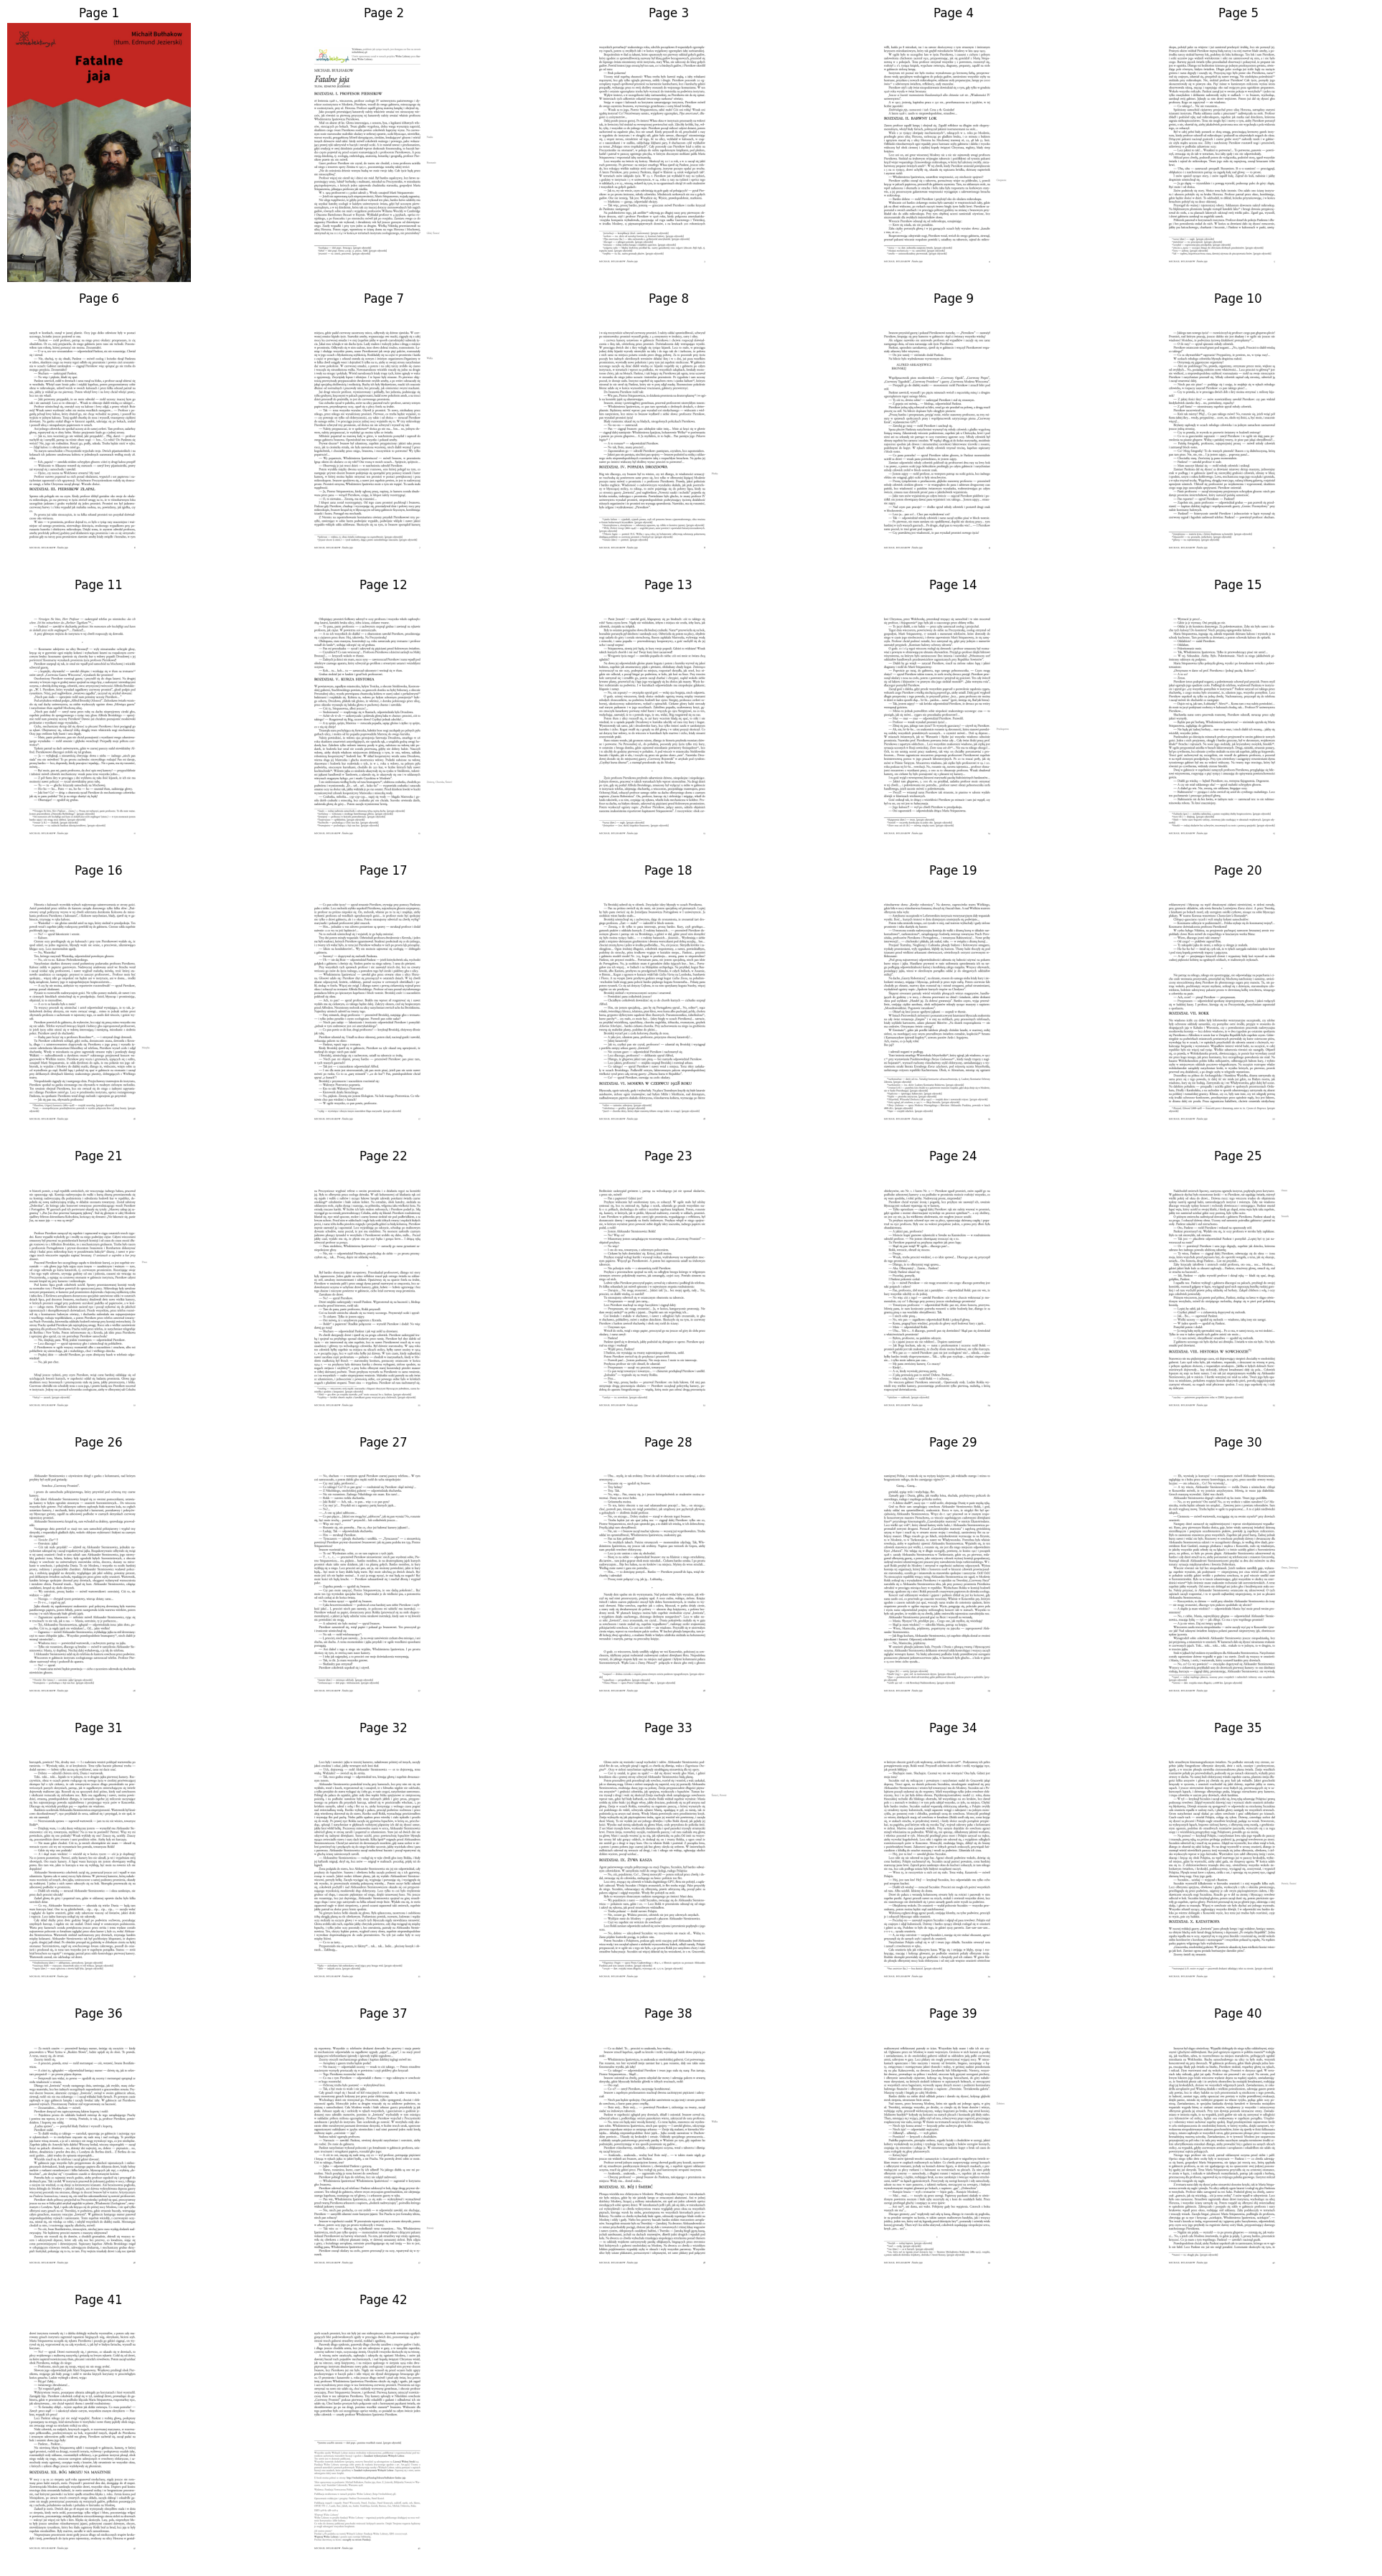

In [5]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

def display_pdf_images(images_list):
    """Display all images in the provided list as subplots with 5 images per row."""
    num_images = len(images_list)
    num_rows = num_images // 5 + (1 if num_images % 5 > 0 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    if num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    else:
        axes = axes.flatten()
    for i, img in enumerate(images_list):
        if i < len(axes):
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Page {i+1}")
            ax.axis('off')
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

pdf_images = convert_from_path("department-of-labor-data.pdf")

display_pdf_images(pdf_images)

## Create RAG Index

We create a RAG index over the PDF using the [`byaldi`](https://github.com/AnswerDotAI/byaldi) library with `colnomic-embed-multimodal` as our retriever.

**Note: This is *much* faster on GPU than CPU.**

In [ ]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained(
    "nomic-ai/colnomic-embed-multimodal-3b",
    device="cuda:0"
)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/800 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

In [ ]:
RAG.index(
    input_path="department-of-labor-data.pdf",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

## Setup Retrieval and VLM Querying

The `query_image` function uses a vision-language model (VLM) to ask a question of an image, which we will use to answer the user query.

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL.Image import Image

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

def query_vlm(query: str, images: list[Image]) -> str:
    """Queries Qwen VLM with text and images"""
    system_prompt = "You are an expert professional PDF analyst who gives rigorous in-depth answers."
    message_content = [
        {"type": "image", "image": image}
        for image in images
    ] + [{"type": "text", "text": query}]
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        },
        {
            "role": "user",
            "content": message_content
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=1000)
    generated_ids_trimmed = generated_ids[0][len(inputs.input_ids[0]):]
    return processor.decode(generated_ids_trimmed, skip_special_tokens=True)

## Plotting Helper Function

In [ ]:
import textwrap
from matplotlib import gridspec
import numpy as np

def plot_rag_result(query: str, answer: str, images: list[Image]) -> None:
    """Plots user query, retrieved source doc as image(s), and VLM answer"""
    wrapped_query = '\n'.join(textwrap.wrap(query, width=70))
    num_images = len(images)
    fig = plt.figure(figsize=(14, 10))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    if num_images == 1:
        ax1 = fig.add_subplot(outer[0])
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title("Source Document\nretrieved by ColNomic Embed Multimodal",
                      fontsize=12, fontweight='bold', loc='left', pad=0)
    else:
        left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
        fig.text(0.1, 0.9, "Source Documents\nretrieved by ColNomic Embed Multimodal",
                fontsize=12, fontweight='bold', va='top', ha='left')
        if num_images == 2:
            rows, cols = 1, 2
        else:
            cols = min(int(np.ceil(np.sqrt(num_images))), 3)
            rows = int(np.ceil(num_images / cols))
        inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=left[0],
                                                wspace=0.05, hspace=0.05)
        for i, image in enumerate(images):
            ax_sub = fig.add_subplot(inner[i])
            ax_sub.imshow(image)
            ax_sub.axis('off')
    ax2 = fig.add_subplot(outer[1])
    ax2.axis('off')
    ax2.set_title("Answer generated by Qwen 2.5 VL 7B Instruct", fontsize=12, fontweight='bold', loc='left')
    wrapped_answer = '\n'.join(['\n'.join(textwrap.wrap(line, width=70)) for line in answer.split('\n')])
    fontsize = 9
    if len(wrapped_answer) > 1500:
        fontsize = 8
        if len(wrapped_answer) > 2500:
          fontsize = 7

    ax2.text(0.02, 0.97, wrapped_answer, transform=ax2.transAxes, fontsize=fontsize, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2C3E50', linewidth=2, pad=1.0))
    fig.suptitle(f"Query: {wrapped_query}", fontsize=14, fontweight='bold', y=0.96)
    plt.show()

Now we'll display the page in more detail so you can see how the model's answers align with the retrieved source page.

# Multi Document Retrieval

In [ ]:
multi_doc_query = "O czym jest rozdział trzeci? Na której stronie się zaczyna i na której kończy?"
K = 2
multi_doc_rag_results = RAG.search(multi_doc_query, k=K)
multi_doc_images = [pdf_images[multi_doc_rag_results[i]["page_num"] - 1] for i in range(K)]
multi_doc_answer = query_vlm(multi_doc_query, multi_doc_images)

In [ ]:
plot_rag_result(multi_doc_query, multi_doc_answer, multi_doc_images)

Now we'll display the pages in more detail so you can see how the model's answers align with the retrieved source pages.

In [ ]:
multi_doc_images[0]

In [ ]:
multi_doc_images[1]

In [ ]:
print(multi_doc_answer)